In [1]:
%matplotlib inline

import os.path as path
import stripack
import numpy as np

import pyproj
import gdal


import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.colorbar as colorbar

In [2]:
def spherical_midpoints(interpolator):

    import pyproj
    
    lst = interpolator.lst
    lend = interpolator.lend
    lptr = interpolator.lptr

    g = pyproj.Geod(ellps='WGS84')

    midlon_array = np.ones((len(lptr))) * -99999.0
    midlat_array = np.ones((len(lptr))) * -99999.0
    
    lonv1 = interpolator.lons
    latv1 = interpolator.lats


    for i in range(0,len(lptr),1):
        n1 = lst[i]-1
        n2 = lst[lptr[i]-1]-1
        if n1 < n2:
            midlonlat, = g.npts(lonv1[n1],latv1[n1],lonv1[n2],latv1[n2], 1 , radians=True )
            midlon_array[i] = midlonlat[0]
            midlat_array[i] = midlonlat[1]
            
    valid_points =  np.where(midlon_array != -99999.0 )    

    midlon_array = midlon_array[valid_points[0]]
    midlat_array = midlat_array[valid_points[0]]
    
   
    return midlon_array, midlat_array


def subdivide_triangle(tri, interpolator):
    """
    Add midpoints to sides of triangle tri={n1, n2, n3}
    """
    
    import pyproj
    
    g = pyproj.Geod(ellps='WGS84')

    midlon=[]
    midlat=[]
    
    lonv1 = interpolator.lons
    latv1 = interpolator.lats
    
    # Easiest is to do this by hand, I think
    
    (n1, n2, n3) = tri

    midlonlat, = g.npts(lonv1[n1],latv1[n1],lonv1[n2],latv1[n2], 1 , radians=True )
    midlon.append(midlonlat[0])
    midlat.append(midlonlat[1])

    midlonlat, = g.npts(lonv1[n2],latv1[n2],lonv1[n3],latv1[n3], 1 , radians=True )
    midlon.append(midlonlat[0])
    midlat.append(midlonlat[1])

    midlonlat, = g.npts(lonv1[n3],latv1[n3],lonv1[n1],latv1[n1], 1 , radians=True )
    midlon.append(midlonlat[0])
    midlat.append(midlonlat[1])

    return np.array(midlon), np.array(midlat)


def subdivide_triangle_list(tlist, interpolator):
    
    segments = []
    
    ntri, tris = interpolator.tri_list()
   
    for i in range(0, len(tlist)):   
        (n1, n2, n3) = tris[i]
                  
        segments.append( min((n1,n2), (n2, n1)))
        segments.append( min((n3,n2), (n2, n3)))
        segments.append( min((n3,n1), (n1, n3)))
       
    segList = sorted(list(set(segments)))
        
    new_nodes = split_segments(segList, interpolator)
        
    return new_nodes
   

def subdivide_node_list(nodes_to_refine, interpolator):
    
    segments = []

    for node in nodes_to_refine:
        neighbours = node_neighbours(node, interpolator)
    
        for n1 in neighbours:
            segments.append( min( tuple((node, n1)), tuple((n1, node))) )

    # Unique entries only
    
    
    segList = sorted(list(set(segments)))
        
    new_nodes = split_segments(segList, interpolator)
    
    return new_nodes
    
                                      

def add_spherical_midpoints(interpolator):   
    
    midlon_array, midlat_array = spherical_midpoints(interpolator)
    
    lonv2 = np.concatenate((interpolator.lons, midlon_array), axis=0)
    latv2 = np.concatenate((interpolator.lats, midlat_array), axis=0)
    
    return np.degrees(lonv2), np.degrees(latv2)
    

def node_neighbours(node, interpolator):
    
    lpl = interpolator.lend[node-1]
    lp = lpl
    k = 1

    neighbours = []

    while True:
        lp = interpolator.lptr[lp-1]
        neighbours.append(interpolator.lst[lp-1])
        if (lp == lpl):
            break
        k += 1

    return neighbours
 
    
    
def split_segments(segList, interpolator):  
    
    import pyproj 
    
    g = pyproj.Geod(ellps='WGS84')

    midlon=[]
    midlat=[]
    
    lonv1 = interpolator.lons
    latv1 = interpolator.lats
    
    for segment in segList:
    
        n1 = segment[0]-1
        n2 = segment[1]-1
    
        midlonlat, = g.npts(lonv1[n1],latv1[n1],lonv1[n2],latv1[n2], 1 , radians=True )

        midlon.append(midlonlat[0])
        midlat.append(midlonlat[1])

    
    return np.array(midlon), np.array(midlat)


# hfgrid, hfnorm, hfcount  = weighted_average_to_nodes(lons, lats, fakeflux, interpolator )

def weighted_average_to_nodes(lons, lats, data, interpolator ):

    grid  = np.zeros(interpolator.npts)
    norm  = np.zeros(interpolator.npts)
    count  = np.zeros(interpolator.npts)

    bcc, nodes = interpolator.find_point(np.radians(lons), np.radians(lats))

    # Beware vectorising the reduction operation !!

    for i in range(0, len(data)):

        grid[nodes[i][0]-1] += bcc[i][0] * data[i]
        grid[nodes[i][1]-1] += bcc[i][1] * data[i]
        grid[nodes[i][2]-1] += bcc[i][2] * data[i]

        norm[nodes[i][0]-1] += bcc[i][0]
        norm[nodes[i][1]-1] += bcc[i][1]
        norm[nodes[i][2]-1] += bcc[i][2]
        
        count[nodes[i][0]-1] += 1
        count[nodes[i][1]-1] += 1
        count[nodes[i][2]-1] += 1

    grid[np.where(norm > 0.0)] /= norm[np.where(norm > 0.0)]
    
    return grid, norm, count


In [3]:
octahedral_vertices = np.array([
    [  0.001,    0.0],
    [ -0.001,   90.0],
    [  0.001,  180.0],
    [ -0.001,  -90.0],
    [ 90.0,      0.0],
    [-90.0,    180.0]]
)


icosohedral_vertices = np.array([
    [ 89.99,      0.1 ],
    [-89.99,      0.2 ],
    [ 26.57,      0.0 ], 
    [-26.57,     36.0 ], 
    [ 26.57,     72.0 ],
    [-26.57,    108.0 ],        
    [ 26.57,    144.0 ],
    [-26.57,    180.0 ],        
    [ 26.57,    -72.0 ],
    [-26.57,    -36.0 ],
    [ 26.57,   -144.0 ],
    [-26.57,   -108.0 ]]        
)


# vertices_lat = octahedral_vertices.T[0]
# vertices_lon = octahedral_vertices.T[1]

vertices_lat = icosohedral_vertices.T[0]
vertices_lon = icosohedral_vertices.T[1]


In [4]:
interpolator0 = stripack.trmesh(np.radians(vertices_lon), np.radians(vertices_lat) )

# subdivide a number of times

lonv1, latv1 = add_spherical_midpoints(interpolator0)
interpolator1 = stripack.trmesh(np.radians(lonv1), np.radians(latv1) )

lonv1, latv1 = add_spherical_midpoints(interpolator1)
interpolator2 = stripack.trmesh(np.radians(lonv1), np.radians(latv1) )

lonv1, latv1 = add_spherical_midpoints(interpolator2)
interpolator3 = stripack.trmesh(np.radians(lonv1), np.radians(latv1) )

lonv1, latv1 = add_spherical_midpoints(interpolator3)
interpolator4 = stripack.trmesh(np.radians(lonv1), np.radians(latv1) )

# lonv1, latv1 = add_spherical_midpoints(interpolator4)
# interpolator5 = stripack.trmesh(np.radians(lonv1), np.radians(latv1) )

# lonv1, latv1 = add_spherical_midpoints(interpolator5)
# interpolator6 = stripack.trmesh(np.radians(lonv1), np.radians(latv1) )

# lonv1, latv1 = add_spherical_midpoints(interpolator6)
# interpolator7 = stripack.trmesh(np.radians(lonv1), np.radians(latv1) )

print "Size of mesh - 1 ", interpolator1.npts
print "Size of mesh - 2 ", interpolator2.npts
print "Size of mesh - 3 ", interpolator3.npts
print "Size of mesh - 4 ", interpolator4.npts
# print "Size of mesh - 5 ", interpolator5.npts
# print "Size of mesh - 6 ", interpolator6.npts
# print "Size of mesh - 7 ", interpolator7.npts


Size of mesh - 1  42
Size of mesh - 2  162
Size of mesh - 3  642
Size of mesh - 4  2562


In [5]:
## Take data and map into the mesh

interpolator = interpolator3


In [6]:
# datafile = "/Users/lmoresi/Dropbox/+Research/Publications/MyPapers/CooperMiller-ContinentalStructure/Notebooks/HeatFlowCont2010.csv"

datafile = "HeatFlowGlobal2010.csv"

heat_flow_data = np.genfromtxt(datafile, delimiter=",",
                               usecols=[3,4,14], comments=None, 
                               missing_values=0.0)

In [7]:
%matplotlib inline

import cartopy
import gdal
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.colors as colors

global_extent     = [-180.0, 180.0, -90.0, 90.0]

projection1 = ccrs.Orthographic(central_longitude=0.0, central_latitude=30, globe=None)
projection2 = ccrs.Mollweide(central_longitude=-120)
projection3 = ccrs.PlateCarree()
base_projection = ccrs.PlateCarree()


In [8]:
valid_map = np.isnan(heat_flow_data)
valid_point = np.empty(heat_flow_data.shape[0])

for i in range(0,len(valid_point)):
    valid_point[i] = np.logical_not(np.any( valid_map[i,:] ))
     
print np.count_nonzero(valid_point), " points are valid"

lons = heat_flow_data[np.where(valid_point),1].reshape(-1)
lats = heat_flow_data[np.where(valid_point),0].reshape(-1)
flux = heat_flow_data[np.where(valid_point),2].reshape(-1)

sensible_range = np.where(flux < 1000.0)

lons = lons[sensible_range[0]]
lats = lats[sensible_range[0]]
flux = flux[sensible_range[0]]

58283  points are valid


In [22]:
## Background image


globaletopo = gdal.Open("../../Data/Resources/ETOPO1_Ice_c_geotiff.tif")
globaletopo_img   = globaletopo.ReadAsArray()[::30,::30]
del globaletopo

from matplotlib.colors import LightSource, Normalize

cmap=plt.cm.Greys
ls = LightSource(315, 45)
hillshade = ls.shade(globaletopo_img, cmap, vert_exag=0.00025)[1::,1::]

## Drop one point here because the data are 361 x 721 !!


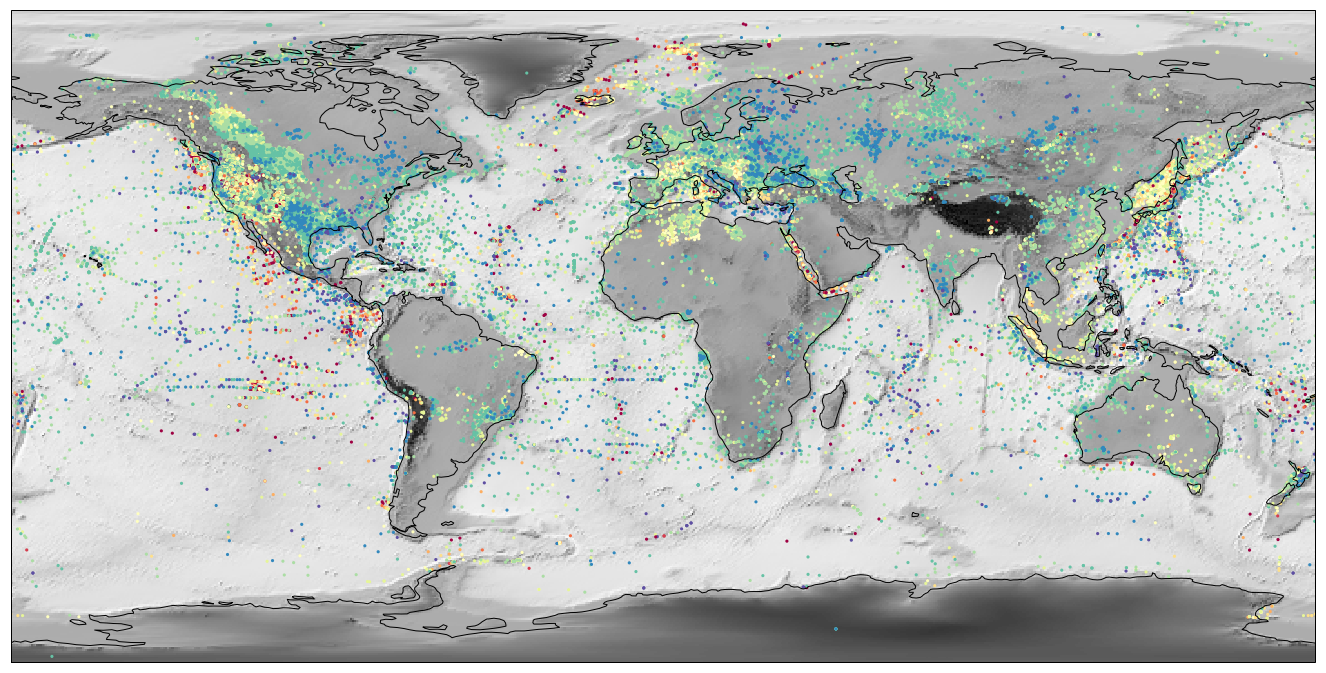

In [23]:
fig = plt.figure(figsize=(24,12), facecolor="none")
ax  = plt.subplot(111, projection=projection3)
ax.coastlines()
ax.set_extent([-140.0,-70.0,20.0,80.0])
ax.set_global()

ax.imshow(hillshade, origin='upper', transform=base_projection, extent=global_extent, zorder=0)

colormap = plt.cm.get_cmap('Spectral_r', 11)
norm = colors.Normalize(vmin=0, vmax=200, clip=True)


m = ax.scatter(lons, lats, c=flux, cmap=colormap, vmin=0, vmax=200, # , norm=norm,
               marker="o", s=10.0, transform=ccrs.Geodetic(), 
               linewidth=0.0, alpha=1.0)

# fig.colorbar(mappable=m, orientation="horizontal", shrink=0.5)
fig.show()

In [11]:
hfgrid, hfnorm, hfcount  = \
weighted_average_to_nodes(lons, lats, flux, interpolator )



nodes_to_refine = np.where(hfnorm > 50)[0] + 1

points = subdivide_node_list(nodes_to_refine, interpolator)

print "Adding ", len(points[0]), " to triangulation (", interpolator.npts," )"

lonv2 = np.concatenate((interpolator.lons, points[0]), axis=0)
latv2 = np.concatenate((interpolator.lats, points[1]), axis=0)

interpolator1x = stripack.trmesh(lonv2, latv2)

hfgrid1x, hfnorm1x, hfcount1x  = weighted_average_to_nodes(lons, lats, flux, interpolator1x )

print hfnorm1x.max()
print hfnorm1x.mean()


nodes_to_refine = np.where(hfnorm1x > 50)[0] + 1

points = subdivide_node_list(nodes_to_refine, interpolator1x)

print "Adding ", len(points[0]), " to triangulation (", interpolator1x.npts," )"

lonv2 = np.concatenate((interpolator1x.lons, points[0]), axis=0)
latv2 = np.concatenate((interpolator1x.lats, points[1]), axis=0)

interpolator2x = stripack.trmesh(lonv2, latv2)

hfgrid2x, hfnorm2x, hfcount2x  = weighted_average_to_nodes(lons, lats, flux, interpolator2x )

print hfnorm2x.max()
print hfnorm2x.mean()


nodes_to_refine = np.where(hfnorm2x > 50)[0] + 1

points = subdivide_node_list(nodes_to_refine, interpolator2x)

print "Adding ", len(points[0]), " to triangulation (", interpolator2x.npts," )"

lonv2 = np.concatenate((interpolator2x.lons, points[0]), axis=0)
latv2 = np.concatenate((interpolator2x.lats, points[1]), axis=0)

interpolator3x = stripack.trmesh(lonv2, latv2)

hfgrid3x, hfnorm3x, hfcount3x  = weighted_average_to_nodes(lons, lats, flux, interpolator3x )

print hfnorm3x.max()
print hfnorm3x.mean()


nodes_to_refine = np.where(hfnorm3x > 50)[0] + 1

points = subdivide_node_list(nodes_to_refine, interpolator3x)

print "Adding ", len(points[0]), " to triangulation (", interpolator3x.npts," )"

lonv2 = np.concatenate((interpolator3x.lons, points[0]), axis=0)
latv2 = np.concatenate((interpolator3x.lats, points[1]), axis=0)

interpolator4x = stripack.trmesh(lonv2, latv2)

hfgrid4x, hfnorm4x, hfcount4x  = weighted_average_to_nodes(lons, lats, flux, interpolator4x )

print hfnorm4x.max()
print hfnorm4x.mean()



nodes_to_refine = np.where(hfnorm4x > 50)[0] + 1

points = subdivide_node_list(nodes_to_refine, interpolator4x)

print "Adding ", len(points[0]), " to triangulation (", interpolator4x.npts," )"

lonv2 = np.concatenate((interpolator4x.lons, points[0]), axis=0)
latv2 = np.concatenate((interpolator4x.lats, points[1]), axis=0)

interpolator5x = stripack.trmesh(lonv2, latv2)

hfgrid5x, hfnorm5x, hfcount5x  = weighted_average_to_nodes(lons, lats, flux, interpolator5x )

print hfnorm5x.max()
print hfnorm5x.mean()


nodes_to_refine = np.where(hfnorm5x > 50)[0] + 1

points = subdivide_node_list(nodes_to_refine, interpolator5x)

print "Adding ", len(points[0]), " to triangulation (", interpolator5x.npts," )"

lonv2 = np.concatenate((interpolator5x.lons, points[0]), axis=0)
latv2 = np.concatenate((interpolator5x.lats, points[1]), axis=0)

interpolator6x = stripack.trmesh(lonv2, latv2)

hfgrid6x, hfnorm6x, hfcount6x  = weighted_average_to_nodes(lons, lats, flux, interpolator6x )

print hfnorm6x.max()
print hfnorm6x.mean()


# nodes_to_refine = np.where(hfnorm5x > 50)[0] + 1

# points = subdivide_node_list(nodes_to_refine, interpolator4x)

# print "Adding ", len(points[0]), " to triangulation (", interpolator4x.npts," )"

# lonv2 = np.concatenate((interpolator4x.lons, points[0]), axis=0)
# latv2 = np.concatenate((interpolator4x.lats, points[1]), axis=0)

# interpolator5x = stripack.trmesh(lonv2, latv2)

# hfgrid5x, hfnorm5x, hfcount5x  = weighted_average_to_nodes(lons, lats, flux, interpolator5x )

# print hfnorm5x.max()
# print hfnorm5x.mean()






Adding  752  to triangulation ( 642  )
1633.70604745
41.1743185079
Adding  955  to triangulation ( 1394  )
766.108636189
24.4346530438
Adding  1000  to triangulation ( 2349  )
554.587213933
17.1385488205
Adding  803  to triangulation ( 3349  )
395.449839627
13.8239402697
Adding  324  to triangulation ( 4152  )
258.936542513
12.823279714
Adding  133  to triangulation ( 4476  )
182.243764655
12.4532436537


In [12]:
ntri, triangles6x = interpolator6x.tri_list()

node_area = np.zeros(interpolator6x.npts)

for tri in triangles6x.T:
    tri_area = interpolator6x.tri_area(tri)
    node_area[tri-1] += 0.333 * tri_area

# This is a measure of accuracy based on the distance between nodes ...     
    
weight = np.log(1.0 / (node_area))
weight = weight / weight.max()
weight.min(), weight.max()

(0.29728987781238847, 1.0)

In [13]:
plot_interpolator = interpolator6x
plot_hfgrid = hfgrid6x

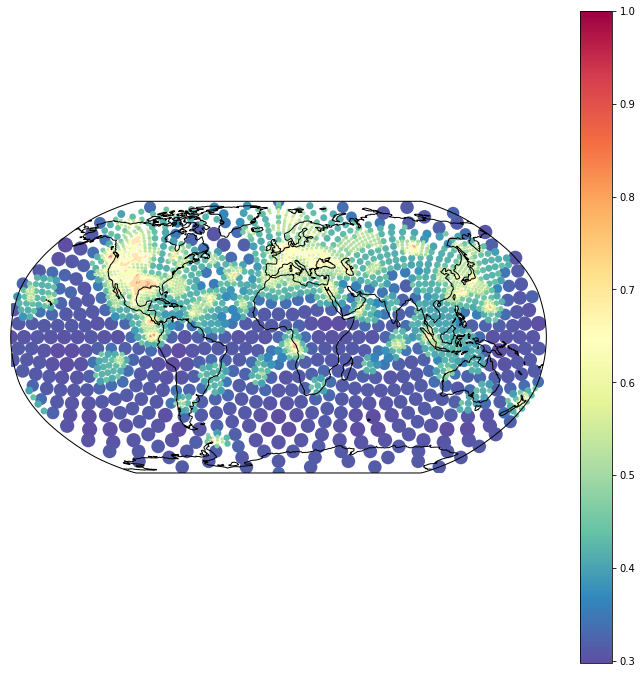

In [14]:
## Quick look to see what we got !


global_extent = [-180.0, 180.0, -90.0, 90.0]

projection1 = ccrs.Orthographic(central_longitude=0.0, central_latitude=80, globe=None)
projection2 = ccrs.Mollweide(central_longitude=-120)
projection3 = ccrs.PlateCarree()
base_projection = ccrs.PlateCarree()

fig = plt.figure(figsize=(12, 12), facecolor="none")
ax  = plt.subplot(111, projection=ccrs.Robinson())
ax.coastlines()
ax.set_global()

plons = np.degrees(plot_interpolator.lons)
plats = np.degrees(plot_interpolator.lats)

m=ax.scatter(plons, plats, c=weight, cmap="Spectral_r", # vmin=0.0, vmax=200.0,
            marker="o", s=10000*node_area, transform=ccrs.Geodetic(), linewidth=0.0)

plt.colorbar(mappable=m)

In [15]:
gridlonv, gridlatv = np.meshgrid(np.linspace(-180,180,720), np.linspace(90,-90,360), sparse=False, indexing='xy')
gridlonv = gridlonv.reshape(-1)
gridlatv = gridlatv.reshape(-1)


In [16]:
interpolator = interpolator6x

hfllgrid = interpolator.interp( np.radians(gridlonv), np.radians(gridlatv), hfgrid6x, order=1)
hfllnorm = interpolator.interp( np.radians(gridlonv), np.radians(gridlatv), weight, order=1)

hfllnorm.min(), hfllnorm.max()

(0.29729141990319963, 0.97355678432639303)

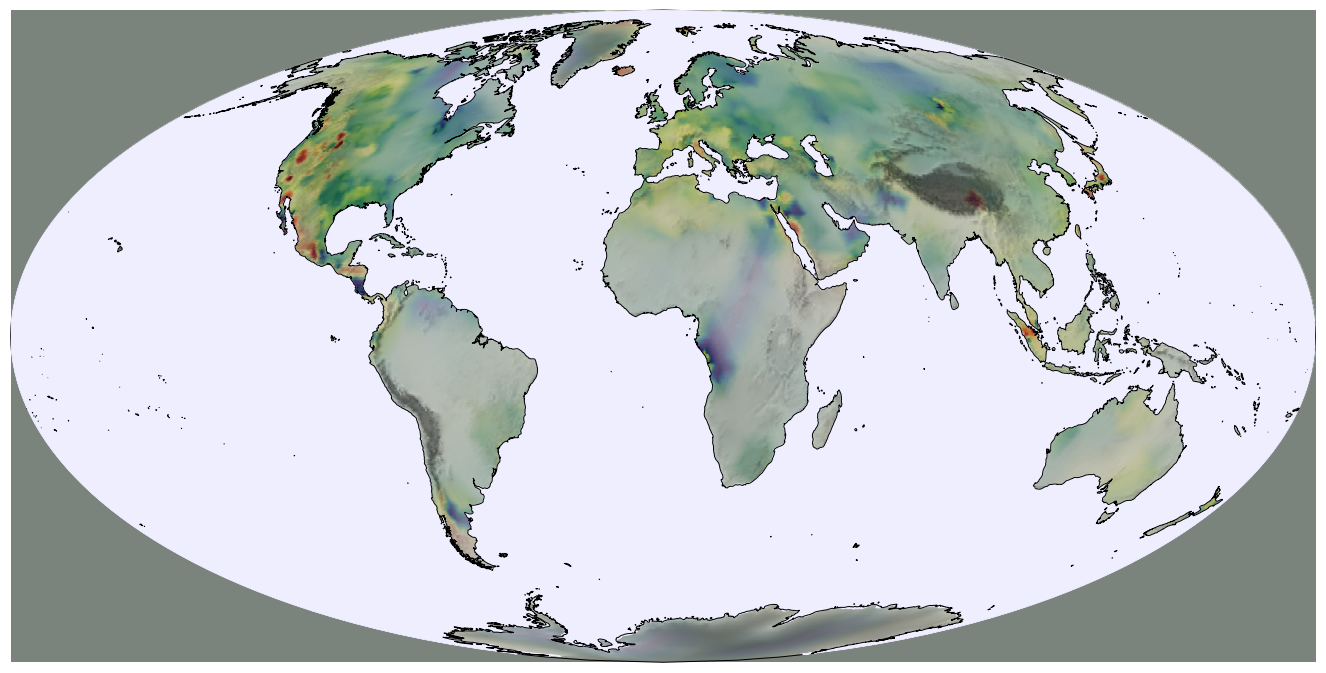

In [17]:
projection = ccrs.Mollweide(central_longitude=0)

fig = plt.figure(figsize=(24,12), facecolor="none", edgecolor="Black", frameon=True)
ax  = plt.subplot(111, projection=projection)

ax.coastlines(linewidth=2.0)
ax.set_extent([-140.0,-70.0,20.0,80.0])
ax.set_global()

colormap = plt.cm.get_cmap('Spectral_r')
norm = colors.Normalize(vmin=0.0, vmax=200.0, clip=False)
col  = colormap(norm(hfllgrid))

## Now lighten the colors to represent areas with no coverage

alpha = 0.05 + 0.95 * ((hfllnorm-hfllnorm.min()) / (hfllnorm.max()-hfllnorm.min()))
# alpha = alpha**0.5

col[:,0] = alpha[:] * col[:,0] + (1.0-alpha[:])
col[:,1] = alpha[:] * col[:,1] + (1.0-alpha[:])
col[:,2] = alpha[:] * col[:,2] + (1.0-alpha[:])

# Apply hillshade image (works if gray cmap is used ... )

col2 = col.reshape(360,720,4)**3 * (0.25 + 0.75 * hillshade)

ax.imshow(col2, origin='upper', transform=base_projection,
          extent=global_extent, zorder=2,  
          interpolation="gaussian")


ax.add_feature(cartopy.feature.OCEAN, alpha=1.0, zorder=99, facecolor="#EEEEFE")
ax.coastlines(resolution="50m", zorder=100)

# ????? 
# cb1 = colorbar.ColorbarBase(ax, cmap=colormap,
#                                 norm=norm,
#                                 orientation='horizontal')

# fig.savefig("ContinentalHeatFlow6x.png", dpi=600)
fig.show()

In [18]:
intensity = hillshade[:,:,0]